In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
import os
from itertools import product
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [2]:
datafolder ='C:/Users/Master/Store_Sales/'

In [3]:
oil= pd.read_csv(os.path.join(datafolder,'oil.csv'))
holidays_events=pd.read_csv(os.path.join(datafolder,'holidays_events.csv'))
stores= pd.read_csv(os.path.join(datafolder,'stores.csv'))
train= pd.read_csv(os.path.join(datafolder,'train.csv'))
test= pd.read_csv(os.path.join(datafolder,'test.csv'))

In [13]:
store_sales = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

oil = pd.read_csv(datafolder + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
oil = oil.asfreq(freq = "D")
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(limit_direction="both")

store_sales = store_sales.merge(oil, how='left', left_index=True, right_index=True)
store_sales['dcoilwtico'].fillna(method='ffill', inplace=True)

In [14]:
store_sales

,dcoilwtico
2013-01-01,93.140000
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667
...,...
2017-08-27,46.816667
2017-08-28,46.400000
2017-08-29,46.460000
2017-08-30,45.960000


In [15]:
store_sales['dofw'] = store_sales.index.dayofweek

In [16]:
hol = pd.read_csv(datafolder + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

hol  = hol .set_index('date').sort_index()
hol  = hol [hol .locale == 'National'] 
hol  = hol .groupby(hol.index).first() # Keep one event only

In [17]:
store_sales['dofw'] = store_sales.index.dayofweek
store_sales['wd'] =1
store_sales.loc[store_sales.dofw > 4, 'wd'] = 0
store_sales = store_sales.merge(hol, how='left', left_index=True, right_index=True)
store_sales.loc[store_sales.type == 'Work Day', 'wd'] = 1 
store_sales.loc[store_sales.type == 'Transfer', 'wd'] = 0 
store_sales.loc[store_sales.type == 'Bridge', 'wd'] = 0 
store_sales.loc[(store_sales.type == 'Store_salesiday') & (store_sales.transferred == False), 'wd'] = 0 
store_sales.loc[(store_sales.type == 'Store_salesiday') & (store_sales.transferred == True), 'wd'] = 1

store_sales.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) 
store_sales

,dcoilwtico,dofw,wd,type
2013-01-01,93.140000,1,1,Holiday
2013-01-02,93.140000,2,1,NaN
2013-01-03,92.970000,3,1,NaN
2013-01-04,93.120000,4,1,NaN
2013-01-05,93.146667,5,1,Work Day
...,...,...,...,...
2017-08-27,46.816667,6,0,NaN
2017-08-28,46.400000,0,1,NaN
2017-08-29,46.460000,1,1,NaN
2017-08-30,45.960000,2,1,NaN


In [18]:
train = pd.read_csv(datafolder + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)
train.date = train.date.dt.to_period('D')
train = train.set_index(['store_nbr', 'family', 'date']).sort_index()

test = pd.read_csv(datafolder + 'test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)
test.date = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [19]:
start_date='2017-04-01'
end_date='2017-08-15'

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
y = train.unstack(['store_nbr', 'family']).loc[start_date:end_date]

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()
X['oil']  = store_sales.loc[start_date:end_date]['dcoilwtico'].values
X['dofw'] = store_sales.loc[start_date:end_date]['dofw'].values
X['wd']   = store_sales.loc[start_date:end_date]['wd'].values
X['type'] = store_sales.loc[start_date:end_date]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

<AxesSubplot:xlabel='date'>

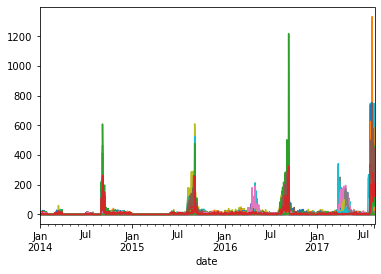

In [25]:
train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [34]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble     import RandomForestRegressor

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,)
        (delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)
        (delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [27]:
model = CustomRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [28]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.258762
BABY CARE                     0.066666
BEAUTY                        0.267092
BEVERAGES                     0.194789
BOOKS                         0.026605
BREAD/BAKERY                  0.121805
CELEBRATION                   0.295325
CLEANING                      0.200247
DAIRY                         0.132328
DELI                          0.105222
EGGS                          0.144453
FROZEN FOODS                  0.142167
GROCERY I                     0.205477
GROCERY II                    0.347022
HARDWARE                      0.273407
HOME AND KITCHEN I            0.258101
HOME AND KITCHEN II           0.218168
HOME APPLIANCES               0.154442
HOME CARE                     0.119974
LADIESWEAR                    0.259059
LAWN AND GARDEN               0.213722
LINGERIE                      0.402536
LIQUOR,WINE,BEER              0.611338
MAGAZINES                     0.254695
MEATS                         0.119278
PERSONAL CARE     

In [30]:
end_test='2017-08-31'
start_test='2017-08-16'
X_test = dp.out_of_sample(steps=16)

X_test['oil']  = store_sales.loc[start_test:end_test]['dcoilwtico'].values
X_test['dofw'] = store_sales.loc[start_test:end_test]['dofw'].values
X_test['wd']   = store_sales.loc[start_test:end_test]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. 

In [31]:
My_submission = pd.read_csv(datafolder + 'sample_submission.csv', index_col='id')
My_submission.sales = sales_pred.values
My_submission.to_csv('submission0616.csv', index=True)

In [32]:
My_submission

,sales
id,
3000888,4.299343
3000889,0.000000
3000890,4.152904
3000891,2430.659776
3000892,0.479325
...,...
3029395,335.125721
3029396,93.172564
3029397,1266.789568
